In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
import sklearn
import pandas as pd
from sklearn.mixture import GaussianMixture

#reference https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian distributions that best classifies the dataset.

### Let's generate an example dataset with four clusters first.

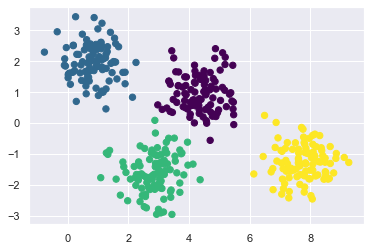

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1]
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');

### Apply a 4-component Gaussian Mixture model 

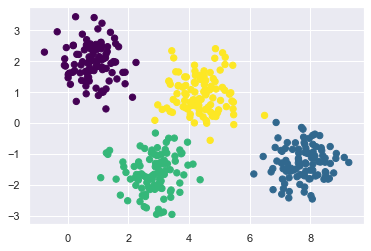

In [3]:
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

### A key benefit of the Gaussian Mixture model is that it can assign the probability of a point data belonging to a certain Gaussian component.

In [4]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

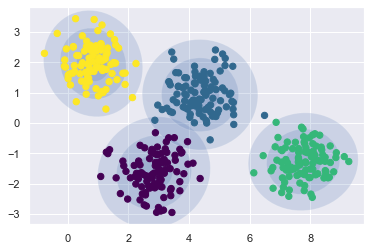

In [5]:
plot_gmm(gmm, X)

In [6]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.537 0.463 0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


### Let's look at an example where Gaussian Mixture Model can be used for image compression

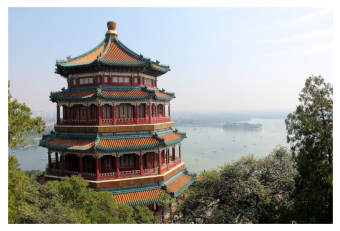

In [7]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [8]:
china.shape

(427, 640, 3)

In [9]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [10]:
def plot_pixels(data, title, colors=None, N=10000, color_centers = None):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))


    fig.suptitle(title, size=20);

    if color_centers is None:
        return
    ax[0].scatter(color_centers[:,0],color_centers[:,1], marker = '*', color = 'Black')
    ax[1].scatter(color_centers[:,0],color_centers[:,2], marker = '*', color = 'Black')

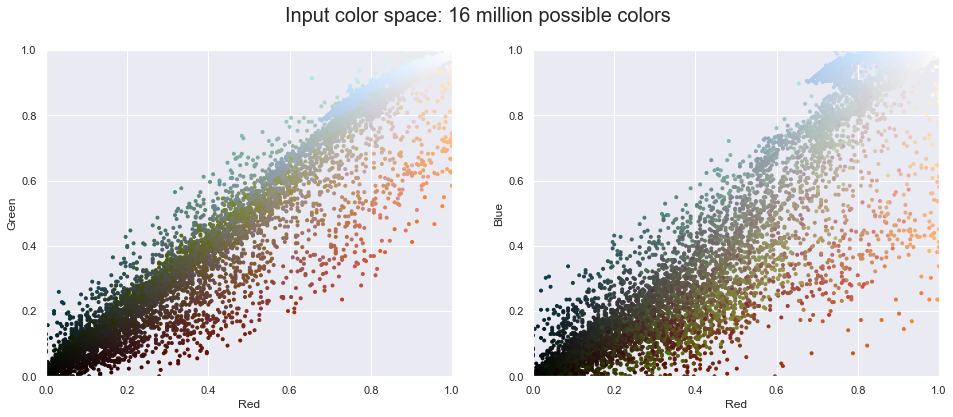

In [11]:
plot_pixels(data, title='Input color space: 16 million possible colors')

In [17]:
import plotly.graph_objs as go
trace = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(
        size=1,
        color='black',               # Set color to the z-values
        colorscale='Viridis',   # Choose a colorscale
        opacity=0.8
    )
)

# Define the layout of the plot
layout = go.Layout(
    scene=dict(
        xaxis_title='R',
        yaxis_title='G',
        zaxis_title='B'
    ),
    title="Interactive 3D Scatter Plot"
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

fig.write_html("RGB_scatter.html")

### Let's reduce the color space from 16 million possible colors to just 16 colors using Gaussian Mixture model!

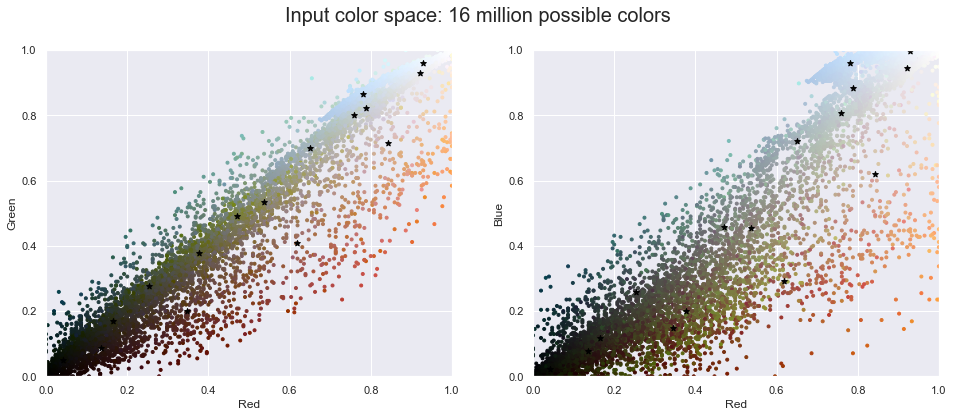

In [13]:
n_component= 16

gmm = GaussianMixture(n_components=n_component).fit(data)
labels = gmm.predict(data)
color_cluster_centers = gmm.means_

#print(np.shape(color_cluster_centers))
plot_pixels(data, title='Input color space: 16 million possible colors',color_centers=color_cluster_centers)
plt.show()
data_condensed = np.copy(data)
for i in range(len(labels)):
    data_condensed[i] = color_cluster_centers[labels[i]]

china_recolored = data_condensed.reshape(china.shape)



In [19]:
trace = go.Scatter3d(
    x=color_cluster_centers[:,0],
    y=color_cluster_centers[:,1],
    z=color_cluster_centers[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color='black',               # Set color to the z-values
        colorscale='Viridis',   # Choose a colorscale
        opacity=0.8
    )
)

# Define the layout of the plot
layout = go.Layout(
    scene=dict(
        xaxis_title='R',
        yaxis_title='G',
        zaxis_title='B'
    ),
    title="Interactive 3D Scatter Plot"
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

fig.write_html("RGB_color_center_scatter.html")

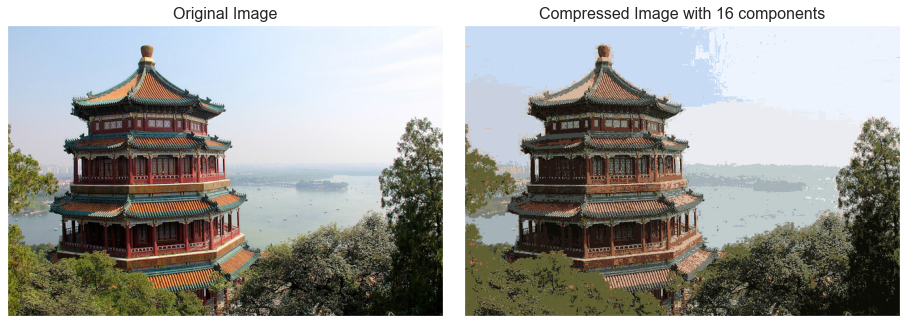

In [14]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                   subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('Compressed Image with '+str(n_component)+' components', size=16);

### Of course, some information has been lost in this compression. However, we did reduce the color space from RGB of (256*256*256 = 16 million) to just 16. The image is still recognizable.

# Exercise
### Classify Known exoplanets into a few broad categories using their masses and radii

Text(0, 0.5, 'log (Planet Mass/Earth Mass)')

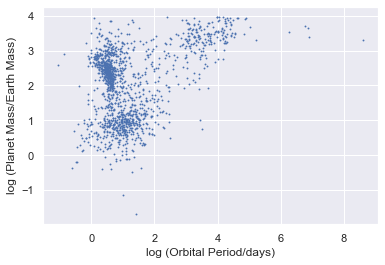

In [15]:
newdata =pd.read_csv('data/exoplanets.csv',header =0)
period = np.array(newdata['pl_orbper'],'d')
mass = np.array(newdata['pl_masse'],'d')

log_period = np.log10(period[(np.isnan(period)==False) & (np.isnan(mass)==False)])
log_mass = np.log10(mass[(np.isnan(period)==False) & (np.isnan(mass)==False)])


plt.scatter(log_period,log_mass, marker = '.', s = 3)
plt.xlabel('log (Orbital Period/days)')
plt.ylabel('log (Planet Mass/Earth Mass)')

### using a Gaussian Mixture Model to classify these planets, how many components do you think are needed?

### show the contours for each Gaussian components

### which component does these two planets belong to 1) log_mass = 2.5, log_period = 1; 2) log_mass = 3, log_period = 2?

### does your model broadly agree with this schematics?

In [16]:
Image(url= "data/exoplanets.png")